In [585]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [1182]:
import crop_sim
import importlib
importlib.reload(crop_sim)

<module 'crop_sim' from '/Users/theron/code/crop-models/crop_sim.py'>

In [1183]:
zip_codes = crop_sim.load_zip("33483")
print(zip_codes)

     ZIP  latitude  longitude
0  33483   26.4546   -80.0656


In [1184]:
# crop_sim.generate_near()

In [1185]:
loca_tasmin, loca_tasmax = crop_sim.load_temperature_data(zip_codes)

In [1186]:
ecocrop_df = crop_sim.load_ecocrop()

In [1208]:


# Select your crop of interest (replace 'Maize' with your desired crop)
crop_name = 'Allium cepa' #onion
crop_name= "Lycopersicon esculentum" # Tomatoes
# crop_name = "Brassica juncea" # Mustard greens
# crop_name = "Vigna unguiculata"
# crop_name = "Ipomoea batatas" # sweet potato
# crop_name = "Solanum tuberosum" # Potato
bolting = False
frost_tolerance = 0

tmin, tmax, topt_min, topt_max, gmin, gmax = crop_sim.load_crop_variables(ecocrop_df, crop_name)

# tmax = 35

In [1209]:
zip_codes = crop_sim.add_loca_index(zip_codes, loca_tasmin, loca_tasmax)

In [1210]:
print(zip_codes['loca_index'].values)

[(23, 30)]


In [1211]:
lat, lon = zip_codes['loca_index'].values[0]

In [1212]:
loca_tasmin_smoothed, loca_tasmax_smoothed = crop_sim.smooth_tas(loca_tasmin, loca_tasmax)

In [1213]:
daily_suitability = crop_sim.suitability(bolting, loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, frost_tolerance)

In [1214]:
# print(daily_suitability.isel(lat=lat, lon=lon))

In [1215]:
growing_season_suitability = crop_sim.calculate_season_suitability(gmin, gmax, daily_suitability)
optimal_planting_ranges = crop_sim.calculate_optimal_planting_ranges(growing_season_suitability, lat, lon)


102
241
28
92
231
18
82
221
8
72
211
62
201
52
191
42
181
32
171
22
161


In [1219]:
view_window = 100
print(optimal_planting_ranges)

{70: [[Timestamp('2022-01-22 12:00:00'), Timestamp('2022-04-27 12:00:00')], [Timestamp('2022-08-27 12:00:00'), Timestamp('2023-04-18 12:00:00')], [Timestamp('2023-09-11 12:00:00'), Timestamp('2023-10-02 12:00:00')]], 80: [[Timestamp('2022-01-22 12:00:00'), Timestamp('2022-04-17 12:00:00')], [Timestamp('2022-08-27 12:00:00'), Timestamp('2023-04-08 12:00:00')], [Timestamp('2023-09-11 12:00:00'), Timestamp('2023-09-22 12:00:00')]], 90: [[Timestamp('2022-01-22 12:00:00'), Timestamp('2022-04-07 12:00:00')], [Timestamp('2022-08-27 12:00:00'), Timestamp('2023-03-29 12:00:00')]], 100: [[Timestamp('2022-01-22 12:00:00'), Timestamp('2022-03-28 12:00:00')], [Timestamp('2022-08-27 12:00:00'), Timestamp('2023-03-19 12:00:00')]], 110: [[Timestamp('2022-01-22 12:00:00'), Timestamp('2022-03-18 12:00:00')], [Timestamp('2022-08-27 12:00:00'), Timestamp('2023-03-09 12:00:00')]], 120: [[Timestamp('2022-01-22 12:00:00'), Timestamp('2022-03-08 12:00:00')], [Timestamp('2022-08-27 12:00:00'), Timestamp('2023-

In [1220]:
import matplotlib
matplotlib.pyplot.close()
optimal_planting_ranges[view_window]

[[Timestamp('2022-01-22 12:00:00'), Timestamp('2022-03-28 12:00:00')],
 [Timestamp('2022-08-27 12:00:00'), Timestamp('2023-03-19 12:00:00')]]

In [1221]:
import crop_sim
import importlib
importlib.reload(crop_sim)
print(crop_sim.merge_overlapping_monthday_ranges(optimal_planting_ranges[view_window]))

[(8, 27, 3, 28)]


In [1222]:
%matplotlib widget

In [1223]:
import matplotlib

In [1224]:
zip_codes['latitude'].values[0]

26.4546

In [1225]:
import ephem
import datetime

observer = ephem.Observer()
observer.lat = str(zip_codes['latitude'].values[0])
observer.lon = str(zip_codes['longitude'].values[0])
observer.pressure = 0  # Disable atmospheric refraction for more accurate sunrise/sunset
sun = ephem.Sun()

start_date = datetime.date(2022, 1, 1)  # Start of the year
end_date = datetime.date(2023, 12, 31)  # End of the year
dates = []
day_lengths = []

current_date = start_date
while current_date <= end_date:
    observer.date = current_date
    try:
        sunrise = observer.next_rising(sun, use_center=True)  # Use center of the sun for accuracy
        sunset = observer.next_setting(sun, use_center=True)

        # Convert sunrise and sunset to local timezone
        sunrise = ephem.localtime(sunrise)#.replace(tzinfo=timezone)
        sunset = ephem.localtime(sunset)#.replace(tzinfo=timezone)

        # Ensure sunset is after sunrise
        if sunset < sunrise:
            sunset += datetime.timedelta(days=1)

        day_length = sunset - sunrise
        dates.append(current_date)
        day_lengths.append(day_length.total_seconds() / 3600)  # Convert to hours
    except ephem.AlwaysUpError:
        # Handle polar days
        dates.append(current_date)
        day_lengths.append(24)
    except ephem.NeverUpError:
        # Handle polar nights
        dates.append(current_date)
        day_lengths.append(0)
    current_date += datetime.timedelta(days=1)
    # try:
        
    #     current_datetime = datetime.datetime.combine(current_date, datetime.time(3, 0))  
    #     sunrise = sun.get_sunrise_time(current_datetime)
    #     sunset = sun.get_sunset_time(current_datetime)
    #     day_length = sunset - sunrise
    #     print([day_length, sunset, sunrise])
    #     dates.append(current_date)
    #     day_lengths.append(day_length.total_seconds() / 3600)  # Convert to hours
    # except SunTimeException:
    #     # Handle days without sunrise/sunset (e.g., polar regions)
    #     dates.append(current_date)
    #     day_lengths.append(0)  # Or some appropriate value
    current_date += datetime.timedelta(days=1)


In [1226]:
# print(day_lengths)
import numpy as np
day_lengths = np.array(day_lengths)
print(day_lengths.shape)
# day_lengths = np.where((day_lengths >= 14) & (day_lengths <= 16), day_lengths, 0)
print(day_lengths.shape)

(365,)
(365,)


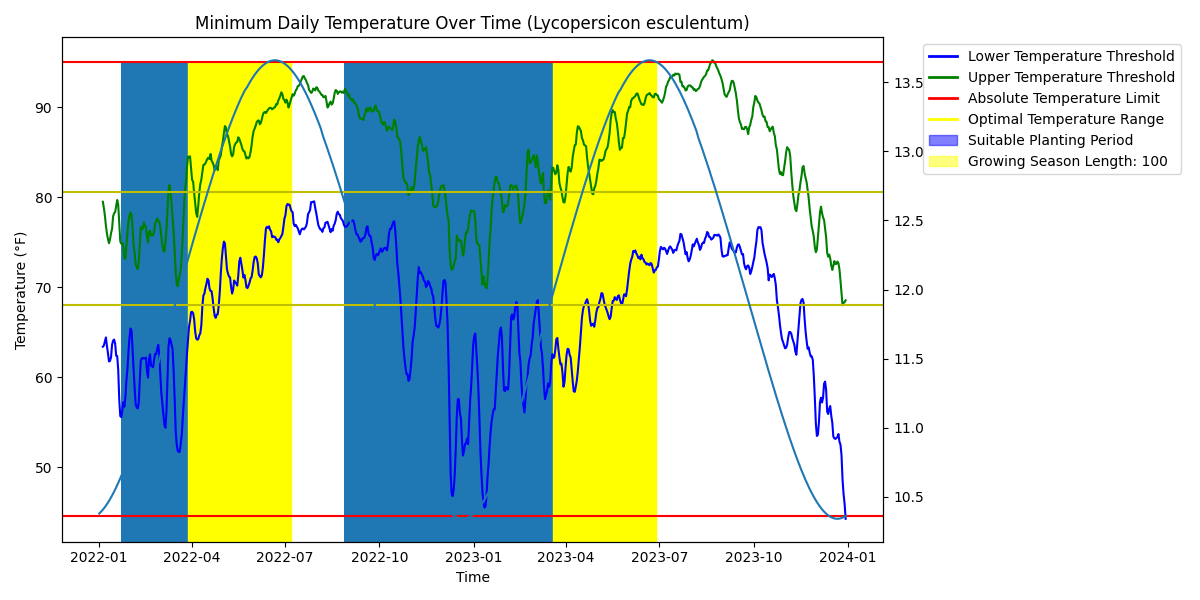

In [1227]:
crop_sim.plot_planting(loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, view_window, optimal_planting_ranges, lat, lon, crop_name, day_lengths, dates)


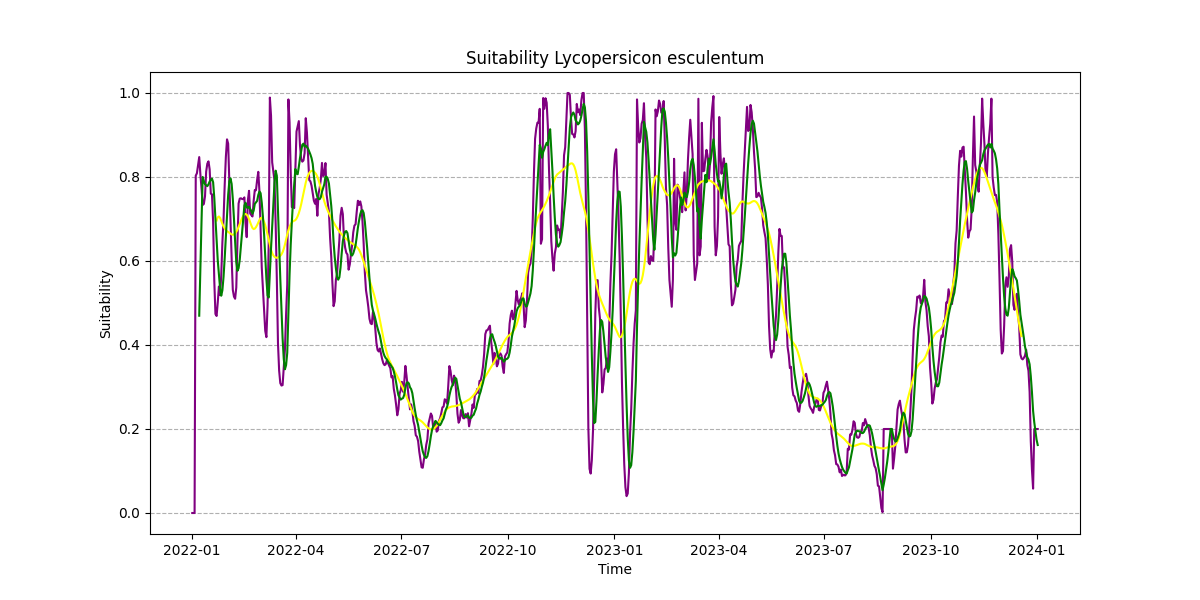

In [1228]:
crop_sim.plot_suitability(view_window, growing_season_suitability, daily_suitability, lat, lon, crop_name)

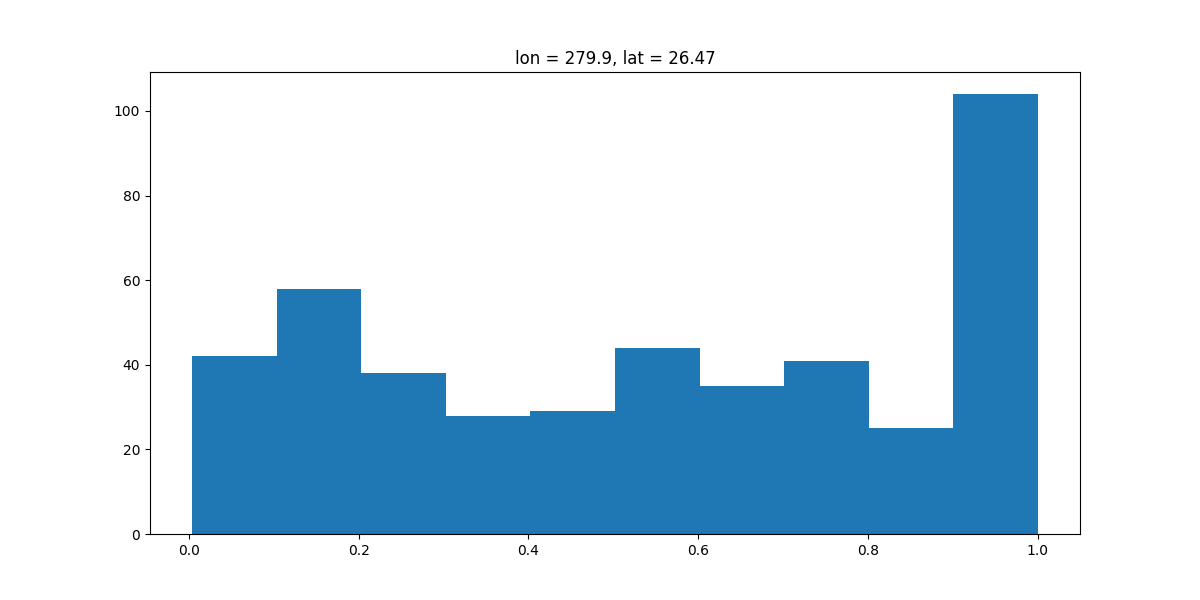

In [1205]:
plt.subplots(figsize=(12, 6))
a = xr.plot.hist(growing_season_suitability[view_window].isel(lat=lat,lon=lon))
plt.show()

In [1207]:
growing_season_suitability[view_window].isel(lat=lat,lon=lon).quantile(0.2)

<xarray.DataArray ()> Size: 8B
array(0.19347935)
Coordinates:
    quantile  float64 8B 0.2

In [631]:
# import pandas as pd
# import xarray as xr
# tasmin = loca_tasmin.isel(lon=lon,lat=lat)
# # frost_days = pd.Series(tasmin < 273.15).rolling(window=7, min_periods=1).sum().to_numpy()
# frost_days = (tasmin < 273.15)

# # nippy_days = pd.Series(((tasmin < tmin + 273.15) & (tasmin > 273.15)).astype(int)).rolling(window=7, min_periods=1).sum().to_numpy()
# groups = frost_days.cumsum()
# group_sizes = groups.groupby(groups).count()
# max_consecutive_frost_days = 1
# extended_frost_mask = xr.ones_like(groups, dtype=bool)
# for group_number, size in group_sizes.to_pandas().items():  # Convert to Pandas for easier iteration
#     if size > max_consecutive_frost_days:
#         extended_frost_mask = xr.where(groups == group_number, False, extended_frost_mask)



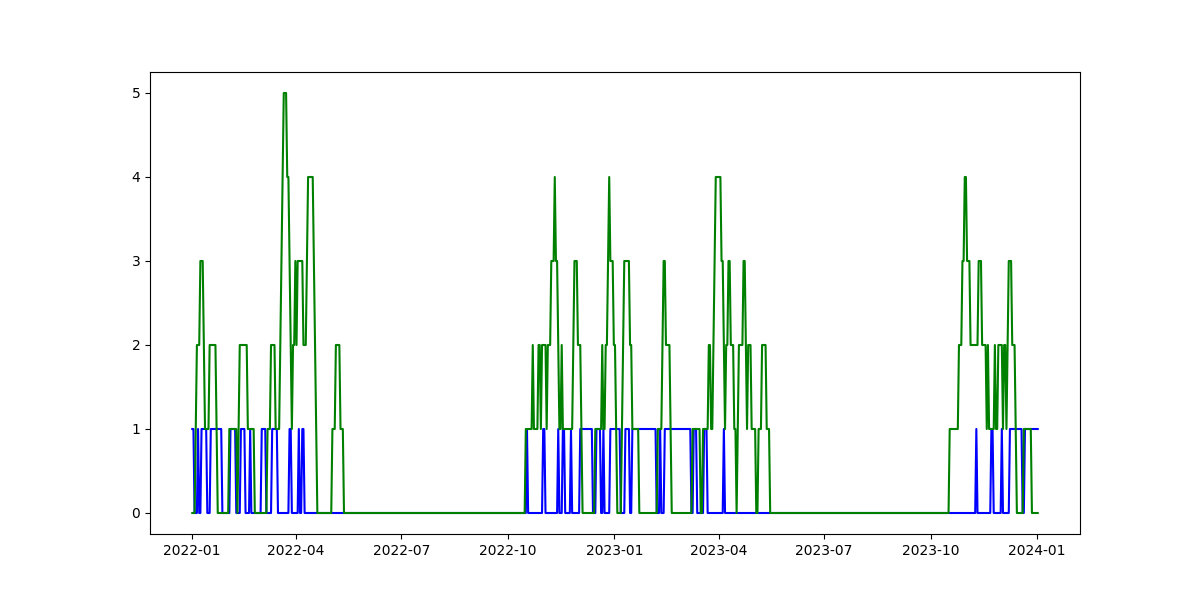

In [634]:
# import matplotlib.pyplot as plt
# fig, ax1 = plt.subplots(figsize=(12, 6))
# ax1.plot(tasmin.time, extended_frost_mask, linestyle='-', color='blue')
# ax1.plot(tasmin.time, nippy_days, linestyle='-', color='green')
# plt.show()